In [ ]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


def plot_detected_sources(
    grid, bounding_boxes, cmap="seismic", title="Detected Magnetic Sources"
):
    """
    Plot a 2D grid and overlay rectangles for detected boxdows.

    Parameters
    ----------
    grid : xr.DataArray
        The 2D grid to be plotted.
    bounding_boxes : list of lists
        Bounding boxes of detected anomalies in data coordinates. Each
        bounding box corresponds to a detected blob, defined by the
        coordinates and size of the blob.
    cmap : str
        Colormap for the background grid.
    """
    fig, ax = plt.subplots()
    grid.plot.pcolormesh(ax=ax, cmap=cmap)
    for box in bounding_boxes:
        rect = mpatches.Rectangle(
            xy=[box[0], box[2]],
            width=box[1] - box[0],
            height=box[3] - box[2],
            edgecolor="k",
            fill=False,
            linewidth=2,
        )
        ax.add_patch(rect)
    ax.set_title(title)
    plt.show()

/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


AttributeError: 'QuadMesh' object has no attribute 'add_patch'

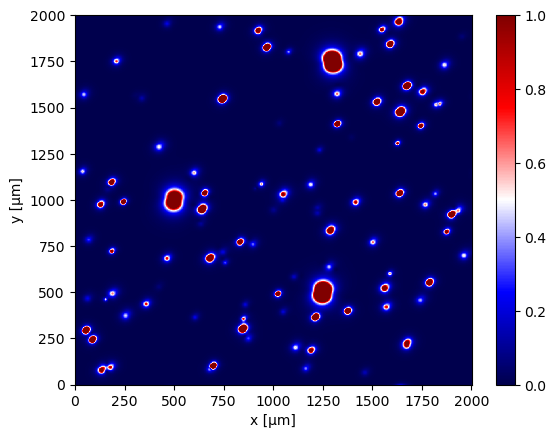

In [2]:
import harmonica as hm
import numpy as np
import skimage.exposure

import magali as mg

sensor_sample_distance = 5.0  # µm
region = [0, 2000, 0, 2000]  # µm
spacing = 2  # µm
size = 100
inc, dec = mg.random_directions(30, 40, 5, size=size, random_state=5)
amp = abs(np.random.normal(0, 100, size)) * 1.0e-14
coords = (
    np.concatenate([np.random.randint(30, 1970, size), [1250, 1300, 500]]),
    np.concatenate([np.random.randint(30, 1970, size), [500, 1750, 1000]]),
    np.concatenate([np.random.randint(-20, -1, size), [-15, -15, -30]]),
)
moments = hm.magnetic_angles_to_vec(
    inclination=np.concatenate([inc, [10, -10, -5]]),
    declination=np.concatenate([dec, [10, 170, 190]]),
    intensity=np.concatenate([amp, [5e-11, 5e-11, 5e-11]]),
)
data = mg.dipole_bz_grid(region, spacing, sensor_sample_distance, coords, moments)
height_diff = 5
data_up = (
    hm.upward_continuation(data, height_diff)
    .assign_attrs(data.attrs)
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_diff)
)
tga = mg.total_gradient_amplitude_grid(data_up)
tga_stretched = skimage.exposure.rescale_intensity(
    tga, in_range=tuple(np.percentile(tga, (1, 99)))
)
windows = mg.detect_anomalies(
    tga_stretched,
    size_range=[25, 50],
    size_multiplier=2,
    num_scales=10,
    detection_threshold=0.01,
    overlap_ratio=0.5,
    border_exclusion=1,
)
plot_detected_sources(tga_stretched, windows)